# Capacity vs. sorter

author: steeve.laquitaine@epfl.ch  

### Setup

Setup `manifold` env

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import kruskal
import scikit_posthocs as sp
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.code import igeom
from src.nodes.analysis.stats import stats


# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]
IGEOM_SORT = data_conf["analyses"]["neural_code"]["by_sorter"]["igeom"]

# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# STATISTICAL PARAMETERS
N_BOOT = 20

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

2024-10-22 21:16:44,948 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-22 21:16:45,009 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (1s)Custom functions

In [2]:
def get_mean_capacity(sorter, igeom_df):

    # full ground truth capacity (expressed as percent change above lower bound)
    gt_full_cap = np.mean(igeom_df[igeom_df.Sorter == "ground_truth"].Capacity) - 1

    # caoacity for randomly sampling population (expressed as percent change above lower bound)
    mean_capacity = igeom_df[igeom_df.Sorter == sorter]["Capacity"].mean() - 1
    print(
        f"""{sorter} mean capacity: {mean_capacity} vs full gt: {gt_full_cap}; changed by {(gt_full_cap - mean_capacity) / gt_full_cap}"""
    )
    return (gt_full_cap - mean_capacity) / gt_full_cap


def get_capacity_for(igeom_df, sorter):
    return igeom_df[igeom_df.Sorter == sorter]["Capacity"].values


def get_var_for(igeom_df, sorter, variable):
    return igeom_df[igeom_df.Sorter == sorter][variable].values


def get_posthoc_dunn_holm_sidak(data, var_names=["oo", "mu", "all", "su", "g"]):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = var_names
    df.index = var_names
    return df

### (14s)Plot

,Capacity,Radius,Dimension,Correlation,K,Unit class,Sorter,Sampling scheme
0,1.283438,0.751657,12.205293,0.140779,1.0,ground_truth,ground_truth,random
1,1.200611,0.770926,12.862726,0.138839,1.0,ground_truth,ground_truth,random
2,1.308170,0.758741,12.285444,0.142411,1.0,ground_truth,ground_truth,random
3,1.303292,0.770258,12.249506,0.138629,1.0,ground_truth,ground_truth,random
4,1.272625,0.762132,12.493953,0.139640,1.0,ground_truth,ground_truth,random
...,...,...,...,...,...,...,...,...
1395,1.134459,0.824111,13.068887,0.144197,1.0,sorted_unit,HS,None
1396,1.133425,0.827836,13.303740,0.145788,1.0,sorted_unit,HS,None
1397,1.144444,0.825041,13.290682,0.139679,1.0,sorted_unit,HS,None
1398,1.124379,0.827000,12.868183,0.143560,1.0,sorted_unit,HS,None


full capacity: 1.2512759571250534
2024-10-22 21:16:45,596 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_80482/2232875930.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


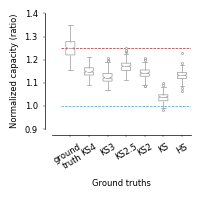

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5))

# LOAD/COMPUTE 1h34 for 0 bootstraps
igeom_df = pd.read_csv(IGEOM_SORT)
display(igeom_df)

# get entire ground truth capacity
gt_full_cap = igeom_df[igeom_df.Sorter == "ground_truth"].Capacity.unique()
print("full capacity:", np.mean(gt_full_cap))

# standardize name for plotting
igeom_df.loc[igeom_df.Sorter == "ground_truth", "Sorter"] = "ground\ntruth"

# set plot parameters
BOXPLOT_PMS = {
    "notch": True,
    "gap": 0.3,
    "width": 0.7,
    "linewidth": 0.5,
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "w",
        "markersize": 1.5,
        "markeredgewidth": 0.5,
    },
}

# highlight lower bound
ax.hlines(xmin=-0.5, xmax=6.5, y=1, color=[0, 0.7, 1], linestyle="--")

# highlight full ground truth capacity
ax.hlines(xmin=-0.5, xmax=6.5, y=np.mean(gt_full_cap), color="red", linestyle="--")

# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="Sorter",
    y="Capacity",
    palette=["white"],
    **BOXPLOT_PMS,
)

# legend
ax.set_ylabel("Manifold capacity / \nlower bound (ratio)")
ax.set_xlabel("Spike sorter")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# disconnected axes
ax.set_ylim(bottom=0.9)
ax.set_ylim(top=1.4)
ax.set_xlim(left=-1)

ax.set_xlabel("Ground truths")
ax.spines["bottom"].set_position(("axes", -0.05))
ax.set_ylabel("Normalized capacity (ratio)")
ax.spines["left"].set_position(("axes", -0.05))
plt.xticks(rotation=30)

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/fig7B_capacity_by_sorter.svg",
)

### Hypothesis testing: degradation of capacity by sorter

* effect of lower yield (sub-sampling) dissociated from the effect of unit type sampling bias.

In [4]:
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# standardize ground truth condition
print("Capacity degradation:\n")
igeom_df.loc[igeom_df.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

# measure degradation induced by sub-sampling
mean_change = []
for s_i in sorters:
    mean_change.append(get_mean_capacity(s_i, igeom_df))
print("\naverage capacity change:", np.mean(mean_change))
print("max change:", np.max(mean_change))
print("min change:", np.min(mean_change))

# standardize ground truth condition
igeom_df.loc[igeom_df.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

print("\nStats:\n")

# calculate one t-test stats
stats.get_ttest_gt_vs_sorter(igeom_df, "KS4")
stats.get_ttest_gt_vs_sorter(igeom_df, "KS3")
stats.get_ttest_gt_vs_sorter(igeom_df, "KS2.5")
stats.get_ttest_gt_vs_sorter(igeom_df, "KS2")
stats.get_ttest_gt_vs_sorter(igeom_df, "KS")
stats.get_ttest_gt_vs_sorter(igeom_df, "HS")

Capacity degradation:

KS4 mean capacity: 0.14910164207960608 vs full gt: 0.25127595712505335; changed by 0.4066219315785865
KS3 mean capacity: 0.12399385205098334 vs full gt: 0.25127595712505335; changed by 0.5065431111291125
KS2.5 mean capacity: 0.17099498280504655 vs full gt: 0.25127595712505335; changed by 0.31949325848176197
KS2 mean capacity: 0.1419697808200613 vs full gt: 0.25127595712505335; changed by 0.4350045167695582
KS mean capacity: 0.036300135638158704 vs full gt: 0.25127595712505335; changed by 0.8555367729826492
HS mean capacity: 0.13207443261860008 vs full gt: 0.25127595712505335; changed by 0.4743849187573877

average capacity change: 0.499597418283176
max change: 0.8555367729826492
min change: 0.31949325848176197

Stats:

Entire ground truth vs KS4: t(199)=-30.922070168032885, p=7.084810918958735e-108
Entire ground truth vs KS3: t(199)=-38.004525236012626, p=1.6681580342568358e-134
Entire ground truth vs KS2.5: t(199)=-24.0775927604103, p=1.090436223860516e-79
Entir

### Hypothesis testing: sorters produce the same capacity? No.

* kruskal wallis
    * compare multiple groups
    * non-parametric so no assumption about the dataset distribution

In [5]:
h, p = kruskal(
    get_capacity_for(igeom_df, "KS4"),
    get_capacity_for(igeom_df, "KS3"),
    get_capacity_for(igeom_df, "KS2.5"),
    get_capacity_for(igeom_df, "KS2"),
    get_capacity_for(igeom_df, "KS"),
    get_capacity_for(igeom_df, "HS"),
)
print(f"H={h}, p={p}")

n_boot = len(get_capacity_for(igeom_df, "KS4"))

print(f"""N = {n_boot} bootstraps""")

H=718.6878046627808, p=4.470611504301811e-153
N = 200 bootstraps


### Posthoc

* Which pairs of sorters produce significantly different capacities?

In [6]:
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]
data = []
for s_i in sorters:
    data.append(get_capacity_for(igeom_df, s_i))

# calculate
df = get_posthoc_dunn_holm_sidak(data, var_names=sorters)
df

,KS4,KS3,KS2.5,KS2,KS,HS
KS4,1.000000e+00,2.080508e-13,1.411741e-08,5.174076e-02,3.380135e-80,3.037913e-07
KS3,2.080508e-13,1.000000e+00,6.556005e-41,1.339823e-07,1.276904e-29,5.174076e-02
KS2.5,1.411741e-08,6.556005e-41,1.000000e+00,9.198512e-15,1.444841e-137,6.840364e-29
KS2,5.174076e-02,1.339823e-07,9.198512e-15,1.000000e+00,3.576732e-64,2.528034e-03
KS,3.380135e-80,1.276904e-29,1.444841e-137,3.576732e-64,1.000000e+00,8.532441e-42
HS,3.037913e-07,5.174076e-02,6.840364e-29,2.528034e-03,8.532441e-42,1.000000e+00


### Geometrics

#### Radius

2024-10-22 10:04:57,728 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_276228/3160605863.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


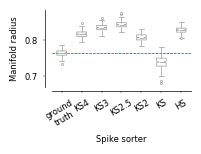

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1))

# highlight full ground truth capacity
gt_radius = igeom_df[igeom_df.Sorter == "ground_truth"].Radius
igeom_df.loc[igeom_df.Sorter == "ground_truth", "Sorter"] = "ground\ntruth"
ax.hlines(xmin=-0.5, xmax=6.5, y=np.mean(gt_radius), color="red", linestyle="--")

# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="Sorter",
    y="Radius",
    palette=["white"],
    **BOXPLOT_PMS,
)

# legend
ax.set_ylabel("Manifold radius")
ax.set_xlabel("Spike sorter")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# disconnected axes
# ax.set_ylim(bottom=0.9)
# ax.set_ylim(top=1.4)
# ax.set_xlim(left=-1)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))

plt.xticks(rotation=30)

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/fig7F_geom_radius_by_sorter.svg",
)

In [77]:
from scipy.stats import ttest_ind


def get_ttest_gt_vs_sorter(df_all: pd.DataFrame, sorter: str, variable):
    """run a one sample t-test for random subset vs ground truth"""

    # get group data
    cap1 = df_all[(df_all["Sorter"] == "ground_truth")][variable].values

    cap2 = df_all[(df_all["Sorter"] == sorter)][variable].values

    # run test
    t, p = ttest_ind(
        cap1,
        cap2,
    )
    dof = len(cap2) - 1
    print(f"""Entire ground truth vs {sorter}: t({dof})={t}, p={p}""")


def get_mean_cap_change(sorter, igeom_df, variable):

    # full ground truth capacity
    gt_var = (
        np.mean(igeom_df[(igeom_df["Sorter"] == "ground_truth")][variable].values) - 1
    )

    # var sorter
    s_var = igeom_df[(igeom_df["Sorter"] == sorter)][variable].values.mean() - 1

    print(
        f"""{sorter} mean: {s_var} vs full gt: {gt_var}; changed by {(s_var - gt_var) / gt_var}"""
    )
    return (s_var - gt_var) / gt_var


def get_mean_geom_change(sorter, igeom_df, variable):

    # full ground truth capacity
    gt_var = np.mean(igeom_df[(igeom_df["Sorter"] == "ground_truth")][variable].values)

    # var sorter
    s_var = igeom_df[(igeom_df["Sorter"] == sorter)][variable].values.mean()

    print(
        f"""{sorter} mean: {s_var} vs full gt: {gt_var}; changed by {(s_var - gt_var) / gt_var}"""
    )
    return (s_var - gt_var) / gt_var

In [87]:
# calculate t-test stats
get_ttest_gt_vs_sorter(igeom_df, "KS4", "Radius")
get_ttest_gt_vs_sorter(igeom_df, "KS3", "Radius")
get_ttest_gt_vs_sorter(igeom_df, "KS2.5", "Radius")
get_ttest_gt_vs_sorter(igeom_df, "KS2", "Radius")
get_ttest_gt_vs_sorter(igeom_df, "KS", "Radius")
get_ttest_gt_vs_sorter(igeom_df, "HS", "Radius")

print("\nRadius change:\n ")

r_k4 = get_mean_geom_change("KS4", igeom_df, "Radius")
r_k3 = get_mean_geom_change("KS3", igeom_df, "Radius")
r_k25 = get_mean_geom_change("KS2.5", igeom_df, "Radius")
r_k2 = get_mean_geom_change("KS2", igeom_df, "Radius")
r_ks = get_mean_geom_change("KS", igeom_df, "Radius")
r_hs = get_mean_geom_change("HS", igeom_df, "Radius")
print("average percent change:", np.mean([r_k4, r_k3, r_k25, r_k2, r_ks, r_hs]))

print("\nKruskall-wallis\n ")

# Kruskall wallis
h, p = kruskal(
    get_var_for(igeom_df, "KS4", "Radius"),
    get_var_for(igeom_df, "KS3", "Radius"),
    get_var_for(igeom_df, "KS2.5", "Radius"),
    get_var_for(igeom_df, "KS2", "Radius"),
    get_var_for(igeom_df, "KS", "Radius"),
    get_var_for(igeom_df, "HS", "Radius"),
)
print(f"H={h}, p={p}")

n_boot = len(get_var_for(igeom_df, "KS4", "Radius"))

print(f"""N = {n_boot} bootstraps""")

# posthoc
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]
data = []
for s_i in sorters:
    data.append(get_var_for(igeom_df, s_i, "Radius"))

# calculate
df = get_posthoc_dunn_holm_sidak(data, var_names=sorters)
df

Entire ground truth vs KS4: t(199)=-58.252829381570415, p=6.629335201550007e-197
Entire ground truth vs KS3: t(199)=-78.40279667170915, p=4.226773348868397e-244
Entire ground truth vs KS2.5: t(199)=-87.86164133064041, p=1.0291803092594704e-262
Entire ground truth vs KS2: t(199)=-45.803287151768465, p=9.25420692953122e-161
Entire ground truth vs KS: t(199)=18.223494419267762, p=2.1659057661200836e-54
Entire ground truth vs HS: t(199)=-68.72852236659901, p=6.668697598654662e-223

Radius change:
 
KS4 mean: 0.8161914336600735 vs full gt: 0.7640628126141865; changed by 0.06822557018255167
KS3 mean: 0.8350355194619461 vs full gt: 0.7640628126141865; changed by 0.09288857627415673
KS2.5 mean: 0.8433666999992585 vs full gt: 0.7640628126141865; changed by 0.10379236638116097
KS2 mean: 0.8069880861949281 vs full gt: 0.7640628126141865; changed by 0.05618029417486743
KS mean: 0.7385231466091043 vs full gt: 0.7640628126141865; changed by -0.03342613406049697
HS mean: 0.8272215384948379 vs full gt

,KS4,KS3,KS2.5,KS2,KS,HS
KS4,1.000000e+00,3.998603e-26,2.479596e-49,6.374233e-05,7.817020e-31,1.630186e-09
KS3,3.998603e-26,1.000000e+00,6.374233e-05,1.382756e-48,6.052204e-111,1.903204e-05
KS2.5,2.479596e-49,6.374233e-05,1.000000e+00,4.437763e-79,2.176574e-155,2.497716e-17
KS2,6.374233e-05,1.382756e-48,4.437763e-79,1.000000e+00,7.112590e-14,5.512751e-24
KS,7.817020e-31,6.052204e-111,2.176574e-155,7.112590e-14,1.000000e+00,3.142551e-71
HS,1.630186e-09,1.903204e-05,2.497716e-17,5.512751e-24,3.142551e-71,1.000000e+00


2024-10-22 10:00:15,887 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_276228/3964598240.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


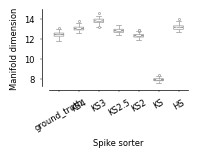

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1))

# highlight full ground truth capacity
gt_dimension = igeom_df[igeom_df.Sorter == "ground\ntruth"].Dimension
ax.hlines(xmin=-0.5, xmax=6.5, y=np.mean(gt_dimension), color="red", linestyle="--")

# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="Sorter",
    y="Dimension",
    palette=["white"],
    **BOXPLOT_PMS,
)

# legend
ax.set_ylabel("Manifold dimension")
ax.set_xlabel("Spike sorter")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# disconnected axes
# ax.set_ylim(bottom=0.9)
# ax.set_ylim(top=1.4)
# ax.set_xlim(left=-1)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))

plt.xticks(rotation=30)

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/fig7G_geom_dimension_by_sorter.svg",
)

In [86]:
variable = "Dimension"

# calculate t-test stats
get_ttest_gt_vs_sorter(igeom_df, "KS4", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS3", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS2.5", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS2", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS", variable)
get_ttest_gt_vs_sorter(igeom_df, "HS", variable)

print(f"\n{variable} change:\n ")

r_k4 = get_mean_geom_change("KS4", igeom_df, variable)
r_k3 = get_mean_geom_change("KS3", igeom_df, variable)
r_k25 = get_mean_geom_change("KS2.5", igeom_df, variable)
r_k2 = get_mean_geom_change("KS2", igeom_df, variable)
r_ks = get_mean_geom_change("KS", igeom_df, variable)
r_hs = get_mean_geom_change("HS", igeom_df, variable)
print("average percent increase:", np.mean([r_k4, r_k3, r_k25, r_hs]))
print("average percent decreasE:", np.mean([r_k2, r_ks]))

print("\nKruskall-wallis\n ")

# Kruskall wallis
h, p = kruskal(
    get_var_for(igeom_df, "KS4", variable),
    get_var_for(igeom_df, "KS3", variable),
    get_var_for(igeom_df, "KS2.5", variable),
    get_var_for(igeom_df, "KS2", variable),
    get_var_for(igeom_df, "KS", variable),
    get_var_for(igeom_df, "HS", variable),
)
print(f"H={h}, p={p}")

n_boot = len(get_var_for(igeom_df, "KS4", variable))

print(f"""N = {n_boot} bootstraps""")

# posthoc
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]
data = []
for s_i in sorters:
    data.append(get_var_for(igeom_df, s_i, "Radius"))

# calculate
df = get_posthoc_dunn_holm_sidak(data, var_names=sorters)
df

Entire ground truth vs KS4: t(199)=-27.34950096979153, p=1.964020806890818e-93
Entire ground truth vs KS3: t(199)=-59.94862141463982, p=2.3321287845006705e-201
Entire ground truth vs KS2.5: t(199)=-18.072542393626065, p=9.741119276986201e-54
Entire ground truth vs KS2: t(199)=4.618657150785767, p=5.2222868821106365e-06
Entire ground truth vs KS: t(199)=234.97322753909705, p=0.0
Entire ground truth vs HS: t(199)=-31.013132517424598, p=3.0956817396431172e-108

Dimension change:
 
KS4 mean: 13.084019876981152 vs full gt: 12.462208855531479; changed by 0.04989573105843721
KS3 mean: 13.861251432070212 vs full gt: 12.462208855531479; changed by 0.11226280932675539
KS2.5 mean: 12.861447580885821 vs full gt: 12.462208855531479; changed by 0.032035952051721245
KS2 mean: 12.36251593839373 vs full gt: 12.462208855531479; changed by -0.007999618550245878
KS mean: 7.931800533563699 vs full gt: 12.462208855531479; changed by -0.3635317281620515
HS mean: 13.188978823526572 vs full gt: 12.462208855531

,KS4,KS3,KS2.5,KS2,KS,HS
KS4,1.000000e+00,3.998603e-26,2.479596e-49,6.374233e-05,7.817020e-31,1.630186e-09
KS3,3.998603e-26,1.000000e+00,6.374233e-05,1.382756e-48,6.052204e-111,1.903204e-05
KS2.5,2.479596e-49,6.374233e-05,1.000000e+00,4.437763e-79,2.176574e-155,2.497716e-17
KS2,6.374233e-05,1.382756e-48,4.437763e-79,1.000000e+00,7.112590e-14,5.512751e-24
KS,7.817020e-31,6.052204e-111,2.176574e-155,7.112590e-14,1.000000e+00,3.142551e-71
HS,1.630186e-09,1.903204e-05,2.497716e-17,5.512751e-24,3.142551e-71,1.000000e+00


2024-10-22 10:00:16,708 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_276228/4242589583.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


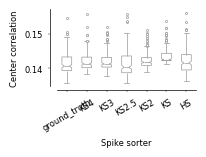

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1))

# highlight full ground truth capacity
gt_corr = igeom_df[igeom_df.Sorter == "ground\ntruth"].Correlation
ax.hlines(xmin=-0.5, xmax=6.5, y=np.mean(gt_corr), color="red", linestyle="--")

# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="Sorter",
    y="Correlation",
    palette=["white"],
    **BOXPLOT_PMS,
)

# legend
ax.set_ylabel("Center correlation")
ax.set_xlabel("Spike sorter")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# disconnected axes
# ax.set_ylim(bottom=0.9)
# ax.set_ylim(top=1.4)
# ax.set_xlim(left=-1)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))

plt.xticks(rotation=30)

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/fig7H_geom_corr_by_sorter.svg",
)

In [85]:
variable = "Correlation"

# calculate t-test stats
get_ttest_gt_vs_sorter(igeom_df, "KS4", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS3", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS2.5", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS2", variable)
get_ttest_gt_vs_sorter(igeom_df, "KS", variable)
get_ttest_gt_vs_sorter(igeom_df, "HS", variable)

print(f"\{variable} change:\n ")

r_k4 = get_mean_geom_change("KS4", igeom_df, variable)
r_k3 = get_mean_geom_change("KS3", igeom_df, variable)
r_k25 = get_mean_geom_change("KS2.5", igeom_df, variable)
r_k2 = get_mean_geom_change("KS2", igeom_df, variable)
r_ks = get_mean_geom_change("KS", igeom_df, variable)
r_hs = get_mean_geom_change("HS", igeom_df, variable)
print("average percent change:", np.mean([r_k3, r_k2, r_ks, r_hs]))

print("\nKruskall-wallis\n ")

# Kruskall wallis
h, p = kruskal(
    get_var_for(igeom_df, "KS4", variable),
    get_var_for(igeom_df, "KS3", variable),
    get_var_for(igeom_df, "KS2.5", variable),
    get_var_for(igeom_df, "KS2", variable),
    get_var_for(igeom_df, "KS", variable),
    get_var_for(igeom_df, "HS", variable),
)
print(f"H={h}, p={p}")

n_boot = len(get_var_for(igeom_df, "KS4", variable))

print(f"""N = {n_boot} bootstraps""")

# posthoc
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]
data = []
for s_i in sorters:
    data.append(get_var_for(igeom_df, s_i, "Radius"))

# calculate
df = get_posthoc_dunn_holm_sidak(data, var_names=sorters)
df

Entire ground truth vs KS4: t(199)=-1.9318056222741702, p=0.05409304211388522
Entire ground truth vs KS3: t(199)=-2.518351073895894, p=0.012181884693496863
Entire ground truth vs KS2.5: t(199)=0.32004426980942413, p=0.7491027166302805
Entire ground truth vs KS2: t(199)=-3.1282399692630722, p=0.0018879549159809877
Entire ground truth vs KS: t(199)=-7.816590923536258, p=4.900106536128806e-14
Entire ground truth vs HS: t(199)=-2.1291911525614218, p=0.03385175391772349
\Correlation change:
 
KS4 mean: 0.14208274758748732 vs full gt: 0.14153334218568223; changed by 0.0038818090021806246
KS3 mean: 0.1422511397769625 vs full gt: 0.14153334218568223; changed by 0.0050715794610330395
KS2.5 mean: 0.14142697202495025 vs full gt: 0.14153334218568223; changed by -0.0007515554927857727
KS2 mean: 0.14236499595029184 vs full gt: 0.14153334218568223; changed by 0.005876027173289949
KS mean: 0.14357924512444906 vs full gt: 0.14153334218568223; changed by 0.01445527186154301
HS mean: 0.14222896138010593 

,KS4,KS3,KS2.5,KS2,KS,HS
KS4,1.000000e+00,3.998603e-26,2.479596e-49,6.374233e-05,7.817020e-31,1.630186e-09
KS3,3.998603e-26,1.000000e+00,6.374233e-05,1.382756e-48,6.052204e-111,1.903204e-05
KS2.5,2.479596e-49,6.374233e-05,1.000000e+00,4.437763e-79,2.176574e-155,2.497716e-17
KS2,6.374233e-05,1.382756e-48,4.437763e-79,1.000000e+00,7.112590e-14,5.512751e-24
KS,7.817020e-31,6.052204e-111,2.176574e-155,7.112590e-14,1.000000e+00,3.142551e-71
HS,1.630186e-09,1.903204e-05,2.497716e-17,5.512751e-24,3.142551e-71,1.000000e+00
